In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sp
from sklearn.preprocessing  import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

c:\python\tf_test\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def configuraConjuntoInicial(caminhoArquivo=None,colunas=None):
    if caminhoArquivo is None:
        caminhoArquivo = 'DECFEC_light_2000_2017.csv'
    dataSet = pd.read_csv(caminhoArquivo)
    # dataSet['Data'] = pd.to_datetime(dataSet["Data"])
    dataSet = dataSet.set_index(["Data"])
    if colunas is not None:
        dataSet = dataSet[colunas]
    return dataSet

In [3]:
def separaConjuntosDeTreinoETeste(conjunto, dataReferencia=None):
    if dataReferencia is None:
        dataReferencia = '2016-01-01'
    conjuntoTreino = conjunto[:dataReferencia]
    conjuntoTreino = conjuntoTreino[:-1]
    conjuntoTeste = conjunto[dataReferencia:]
    return conjuntoTreino,conjuntoTeste

In [4]:
def normalizaConjunto(conjunto):
    
    scaler = MinMaxScaler()
    colunasConjunto = [i for i in conjunto]
    conjuntoNormalizado = scaler.fit_transform(pd.DataFrame(conjunto))
    conjuntoNormalizado  = pd.DataFrame(conjuntoNormalizado, index=conjunto.index,columns=colunasConjunto)
    return conjuntoNormalizado,scaler

In [5]:
def analisePorIntervalosDeProbabilidade(serie,intervalos,showPlot=False):
    valores = serie.values.flatten().tolist()
    prob_acumulada=[]
    conjuntoNormalizado=[]
    for i in range(len(intervalos)):
        ocorrencias = (len([x for x in valores if (x <= intervalos[i])])/len(valores))
        intervalos[i] = round(intervalos[i],2)
        ocorrencias = round(ocorrencias, 5)
        prob_acumulada.append(ocorrencias)
    if(showPlot):
        plt.hist(valores,cumulative=True,density = True)
        plt.title('Distribuição de probabilidade acumulada')
        plt.show()
    print('Intervalos:')
    print(intervalos)
    print('Probabilidades acumuladas:')
    print(prob_acumulada)
    return prob_acumulada, intervalos

In [6]:
def normalizaNumero(numero,probMin,probMax,valorMin,valorMax):
    return (probMin + (numero-valorMin)*(probMax - probMin)/(valorMax - valorMin))

def inverteNormalizacaoNumero(numero,probMin,probMax,valorMin,valorMax):
    return (valorMin + (numero-probMin)*(valorMax - valorMin)/(probMax - probMin))

In [7]:
def normalizaSeriePorTrechos(serie,trechos,probabilidades,showPlot=False):
    
    serie_normalizada = []
    for i in range(serie.size):
        valor = serie.iloc[i].values[0]
        indice_maior = np.where(np.array(trechos)  > valor)[0][0]
        serie_normalizada.append(normalizaNumero(numero=valor,probMin=probabilidades[indice_maior-1],probMax=probabilidades[indice_maior],valorMin=trechos[indice_maior-1],valorMax=trechos[indice_maior]))
    serie_normalizada = np.array(serie_normalizada)
    if(showPlot):
        dataSetparaPlot = pd.DataFrame(serie_normalizada,columns=['Série Normalizada'],index= pd.to_datetime(serie.index)) 
        ax = dataSetparaPlot.plot(figsize=(12,7),grid=True)
        plt.show()
    
    dataSetNormalizado = pd.DataFrame(serie_normalizada,columns=['Série Normalizada'],index=serie.index)
    
    return dataSetNormalizado

def inverteNormalizacaoPorTrechos(serie,trechos,probabilidades,showPlot=False):
    serie_invertida = []
    for i in range(serie.size):
        valor = serie.iloc[i].values[0]
        indice_maior = np.where(np.array(probabilidades)  > valor)[0][0]
        serie_invertida.append(inverteNormalizacaoNumero(numero=valor,probMin=probabilidades[indice_maior-1],probMax=probabilidades[indice_maior],valorMin=trechos[indice_maior-1],valorMax=trechos[indice_maior]))
    serie_invertida = np.array(serie_invertida)
    
    if(showPlot):
        dataSetparaPlot = pd.DataFrame(serie_invertida,index=pd.to_datetime(serie.index))
        dataSetparaPlot.plot(figsize=(12,7),grid=True)
        plt.show()
    
    dataSetInvertido = pd.DataFrame(serie_invertida,columns=['Série'],index=serie.index) 
    
    return dataSetInvertido

In [8]:
def diferenciaSerie(dataset, interval=1):
    data = dataset.values.flatten()
    diff = list()
    for i in range(interval, len(dataset)):
        value = data[i] - data[i - interval]
        diff.append(value)
    index = dataset.index[interval:len(dataset)]
    return pd.DataFrame(data=diff,index=index,columns=[dataset.columns[0]])

def inverteDiferenciaSerie(original, diff):
    data_diff = diff.values.flatten()
    data_original = original.values.flatten()
    inverted = [(data_original[i] + data_diff[i]) for i in range(len(data_diff))]
    return pd.DataFrame(data=inverted,index=diff.index,columns=diff.columns)

In [9]:
def calculaErros(previsao,verdadeiro):
    rmse = (mean_squared_error(verdadeiro, previsao))**0.5
    mape = np.mean(np.abs((verdadeiro - previsao) / verdadeiro)) * 100
    print('Root Mean Squared Error: %f'%rmse)
    print('Mean Absolute Percentage Error: %f'%mape)
    return rmse,mape

In [10]:
def codificaMesesDoConjunto(conjunto):
    mesCodificado = np.array([float(i.split("-")[1])/12 for i in conjunto.index])
    mesCodificado = pd.DataFrame(data=mesCodificado,index=conjunto.index,columns=['mes_codificado'])
    return mesCodificado

In [11]:
def configuraConjuntosDeEntradaEDeReferenciaPorJanelas(conjunto, janelasDeObservacao=12, janelasDeAtraso=0):
    
    conjuntoDeDados = np.ndarray.flatten(conjunto.values)
    dataSetDeEntrada = []
    dataSetDeReferencia = []
    
    for ii in range(len(conjuntoDeDados) - janelasDeObservacao):
        janelaDeDados = conjuntoDeDados[ii:ii+ janelasDeObservacao]
        valorDeReferencia = conjuntoDeDados[ii+janelasDeObservacao]
        dataSetDeEntrada.append(janelaDeDados)
        dataSetDeReferencia.append(valorDeReferencia)
    
    dataSetDeEntrada = np.array(dataSetDeEntrada)
    dataSetDeReferencia = np.array(dataSetDeReferencia)
    conjuntoDeEntrada = pd.DataFrame(dataSetDeEntrada,index=conjunto.index[janelasDeObservacao:])
    conjuntoDeReferencia = pd.DataFrame(dataSetDeReferencia,index=conjunto.index[janelasDeObservacao:])
    return conjuntoDeEntrada,conjuntoDeReferencia

In [12]:
def concatenaConjuntos(conjunto1,conjunto2):
    return pd.concat([conjunto1, conjunto2], axis=1, join='inner')

In [95]:
def configuraRedeMLP(conjuntoEntrada,conjuntoSaida,neuronios_1=None,neuronios_2=None,metricas=['mse'],funcObjetivo='mean_squared_error',showPlot=False):
    
    dimEntrada = len([i for i in conjuntoEntrada])
    conjuntoEntrada = conjuntoEntrada.values
    conjuntoSaida = conjuntoSaida.values
    
    earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 100, verbose = 1)
    K.clear_session()
    model = Sequential()
    if neuronios_1 is None:
        neuronios_1 = 12
    model.add(Dense(neuronios_1,  input_shape=(dimEntrada,),activation='relu'))
    
    if neuronios_2 is not None:
                model.add(Dense(neuronios_2, input_shape=(neuronios_1,), activation='relu'))
                model.add(Dense(neuronios_2, input_shape=(neuronios_2,), activation='relu'))
        
    # model.add(Dense(3, input_shape=(6,), activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=0.001), loss=funcObjetivo,metrics=metricas)
    historico = model.fit(conjuntoEntrada , conjuntoSaida,
                validation_split=0.20, epochs=2000,
                callbacks=[earlyStopping], verbose=0)
    if(showPlot):
        model.summary()
#         plt.plot(historico.history['mean_absolute_error'])
        plt.plot(historico.history['val_loss'])
#         plt.legend(['mean_absolute_error','val_loss'])
        plt.legend(['val_loss'])
        plt.grid(True)
        plt.show()
    return model,historico

In [96]:
def executaPrevisaoDoModelo(modelo,conjuntoEntrada,conjuntoSaida=None,scalerSaida=None,showPlot=False):
    
    previsaoDeDados = modelo.predict(conjuntoEntrada)
    if(showPlot and scalerSaida is not None and conjuntoSaida is not None):
        dadosReais = scalerSaida.inverse_transform(conjuntoSaida)
        previsaoDeDados = scalerSaida.inverse_transform(previsaoDeDados)
        plt.figure(figsize=(12,7))
        plt.plot(dadosReais)
        plt.plot(previsaoDeDados)
        plt.legend(['Real','Previsão'])
        plt.grid(True)
        plt.show()
        return previsaoDeDados,dadosReais
    return previsaoDeDados

In [97]:
def executaPrevisaoEmMultiEstagios(modelo:Sequential,conjuntoEntradaInicial,numeroEstagios,indexPrevisao,horizonte=12):
    
    dadosDeEntrada = conjuntoEntradaInicial.iloc[0:1]
    labels = [i for i in conjuntoEntradaInicial]
    previsaoFinal = []
    
    if numeroEstagios > horizonte:
        horizonteMaximo = range(horizonte)
        iteracoesAdicionais = range(numeroEstagios - horizonte)
    else:
        horizonteMaximo = range(numeroEstagios)
        iteracoesAdicionais = range(0)
    
    for i in horizonteMaximo:
        previsao = executaPrevisaoDoModelo(modelo=modelo,conjuntoEntrada=dadosDeEntrada)
        previsao = previsao.flatten().tolist()[0]
        previsaoFinal.append(previsao)
        if i == (len(horizonteMaximo) - 1):
            if  len(iteracoesAdicionais) > 0:
                dadosDeEntrada = conjuntoEntradaInicial.iloc[i:i+1]
                for j in iteracoesAdicionais:
                            previsao = executaPrevisaoDoModelo(modelo=modelo,conjuntoEntrada=dadosDeEntrada)
                            previsao = previsao.flatten().tolist()[0]
                            previsaoFinal.append(previsao)
                            
                            if j == (numeroEstagios - 1):
                                break
                            proximaEntrada = dadosDeEntrada.drop(columns='mes_codificado').values.flatten().tolist()
                            proximaEntrada.append(previsao)
                            proximaEntrada.append(conjuntoEntradaInicial['mes_codificado'].iloc[i+j+1])
                            proximaEntrada.pop(0)
                            dataFrameDeEntrada = []
                            dataFrameDeEntrada.append(proximaEntrada)
                            dadosDeEntrada = pd.DataFrame(dataFrameDeEntrada,columns=labels)
            break
        proximaEntrada = dadosDeEntrada.drop(columns='mes_codificado').values.flatten().tolist()
        proximaEntrada.append(previsao)
        proximaEntrada.append(conjuntoEntradaInicial['mes_codificado'].iloc[i+1])
        proximaEntrada.pop(0)
        dataFrameDeEntrada = []
        dataFrameDeEntrada.append(proximaEntrada)
        dadosDeEntrada = pd.DataFrame(dataFrameDeEntrada,columns=labels)
        
    previsaoFinal = pd.DataFrame(np.array(previsaoFinal),index=indexPrevisao,columns=['Previsão da série'])
    return previsaoFinal

In [98]:
def comparaPrevisaoComSerieReal(conjuntoReal,previsao):
    plt.figure(figsize=(12,7))
    plt.plot(dadosReais)
    plt.plot(previsaoDeDados)
    plt.legend(['Real','Previsão'])
    plt.grid(True)
    plt.show()

In [99]:
def converteDateStringParaDateTime(conjunto):
    return conjunto.set_index(pd.to_datetime(conjunto.index),drop=True)

# Execução do código a partir daqui

In [126]:
indicador = 'DEC'
conjunto = configuraConjuntoInicial(colunas=[indicador])
# conjunto = conjunto.iloc[132:]
treino,teste = separaConjuntosDeTreinoETeste(conjunto=conjunto,dataReferencia='2014-12-01')

treinoNormalizado,scalerTreino = normalizaConjunto(conjunto=treino)
# probAcumuladaTreino,intervalosTreino = analisePorIntervalosDeProbabilidade(treino,intervalos=[0,1,2,6])
# treinoNormalizado = normalizaSeriePorTrechos(serie=treino,trechos=intervalosTreino,probabilidades=probAcumuladaTreino)
print('')
testeNormalizado,scalerTeste = normalizaConjunto(conjunto=teste)
# probAcumuladaTeste,intervalosTeste = analisePorIntervalosDeProbabilidade(teste,intervalos=[0,1,3])
# testeNormalizado = normalizaSeriePorTrechos(serie=teste,trechos=intervalosTeste,probabilidades=probAcumuladaTeste)

treinoInput,treinoOutput = configuraConjuntosDeEntradaEDeReferenciaPorJanelas(conjunto=treinoNormalizado,janelasDeObservacao=12)
testeInput,testeOutput = configuraConjuntosDeEntradaEDeReferenciaPorJanelas(conjunto=testeNormalizado,janelasDeObservacao=12)


In [127]:
mesCodificadoTreino = codificaMesesDoConjunto(treinoNormalizado)
mesCodificadoTeste = codificaMesesDoConjunto(testeNormalizado)
treinoInput = concatenaConjuntos(conjunto1=treinoInput,conjunto2=mesCodificadoTreino)
testeInput = concatenaConjuntos(conjunto1=testeInput,conjunto2=mesCodificadoTeste)

In [128]:
modelo = Sequential()
modelo,historico = configuraRedeMLP(conjuntoEntrada=treinoInput,conjuntoSaida=treinoOutput,neuronios_1=12,neuronios_2=None,metricas=['mse','mape','mae'],funcObjetivo='mean_squared_error',showPlot=False)


Epoch 00174: early stopping


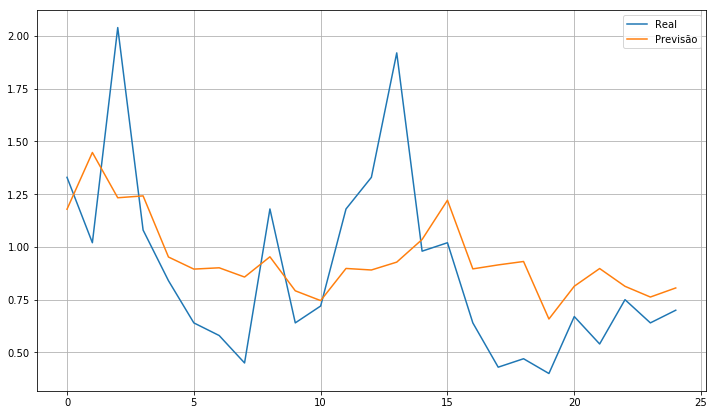

In [132]:
prev_teste = executaPrevisaoEmMultiEstagios(modelo=modelo,conjuntoEntradaInicial=testeInput,numeroEstagios=testeOutput.size,indexPrevisao=testeOutput.index)
scalerSaida = scalerTeste
dadosReais = scalerSaida.inverse_transform(testeOutput)
previsaoDeDados = scalerSaida.inverse_transform(prev_teste)
plt.figure(figsize=(12,7))
plt.plot(dadosReais)
plt.plot(previsaoDeDados)
plt.legend(['Real','Previsão'])
plt.grid(True)
plt.show()


In [130]:
calculaErros(previsao=previsaoDeDados,verdadeiro=dadosReais)

Root Mean Squared Error: 0.366810
Mean Absolute Percentage Error: 37.331640


(0.3668100490904923, 37.33164049642678)

Root Mean Squared Error: 0.399532
Mean Absolute Percentage Error: 38.695874


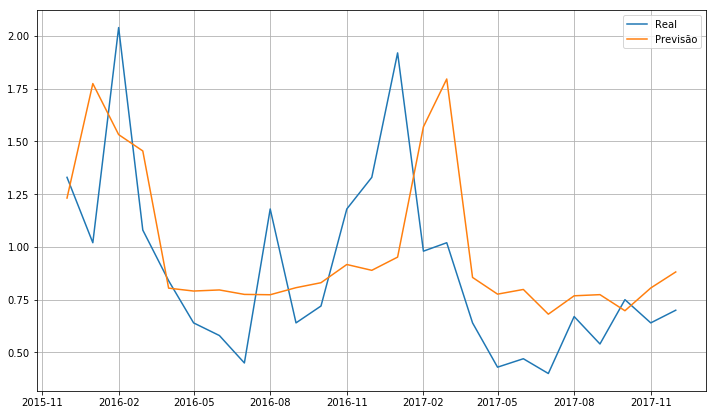

In [49]:
prev_teste = []
prev_teste = executaPrevisaoEmMultiEstagios(modelo=modelo,conjuntoEntradaInicial=testeInput,numeroEstagios=testeOutput.size,indexPrevisao=testeOutput.index)
dadosReais = inverteNormalizacaoPorTrechos(serie=testeOutput,trechos=intervalosTeste,probabilidades=probAcumuladaTeste)
previsaoDeDados = inverteNormalizacaoPorTrechos(serie=prev_teste,trechos=intervalosTeste,probabilidades=probAcumuladaTeste)

calculaErros(previsao=previsaoDeDados.values,verdadeiro=dadosReais.values)

dadosReais = converteDateStringParaDateTime(dadosReais)
previsaoDeDados = converteDateStringParaDateTime(previsaoDeDados)
comparaPrevisaoComSerieReal(conjuntoReal=dadosReais,previsao=previsaoDeDados)

In [50]:
# modelo.summary()
# plt.figure(figsize=(8,6))
# plt.plot(historico.history['val_loss'])
# # plt.plot(historico.history['mean_squared_error'])
# # plt.plot(historico.history['mean_absolute_error'])
# plt.legend(['val_loss'])
# plt.grid(True)
# plt.show()

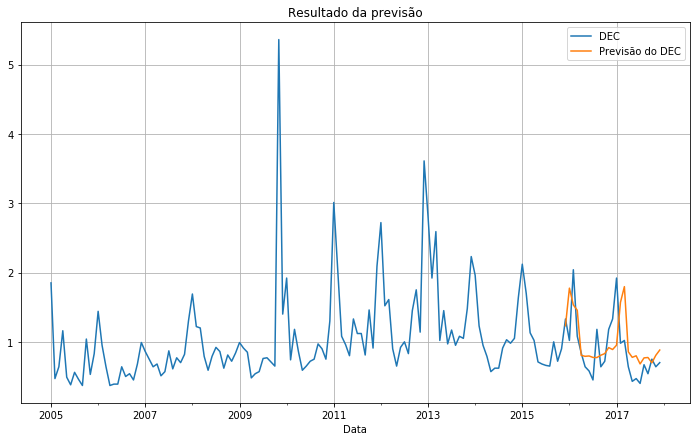

In [51]:
conjuntoTodo = converteDateStringParaDateTime(conjunto)
conjuntoParcial = conjuntoTodo.loc['01-01-2005':'12-01-2017']
# prev_teste pd.DataFrame(prev_teste, columns=['Previsão do FEC'],
previsao_final = pd.DataFrame(previsaoDeDados.values, columns=['Previsão do DEC'], index= pd.to_datetime(teste.iloc[-len(previsaoDeDados):].index))
ax = conjuntoParcial.plot(y=indicador,figsize=(12,7))
previsao_final.plot(y='Previsão do DEC',ax=ax)
plt.title('Resultado da previsão')
plt.grid(True)
plt.show()